In [1]:
warning('off','all');
if ~exist('run_once','var')
curdir = pwd;
cd('../..');
startup;
cd(curdir);
run_once = true;
end

In [2]:
%plot -s 600,400

# Simulate an MVAR process

In [3]:
nchannels = 4;
ntrials = 10;
nsamples = 200;
norder = 3;

s = VAR(nchannels,norder);
% stable = false;
% while stable == false
%     s.coefs_gen_sparse(0.1);
%     disp(s.A);
%     stable = s.coefs_stable(true);
% end

A = [];
A(:,:,1) = [...
    0         0         0         0;...
    -0.0270   0.2767    0         0;...
    0         0         0         0;...
    0         0         0         0;...
    ];

A(:,:,2) = [...
    0         0         0   -0.7183;...
    0         0         0         0;...
    0.4170    0         0         0;...
    0         0         0         0;...
    ];

A(:,:,3) = [...
    0.2643    0         0         0;...
    0.7388   -0.1545    0         0;...
    0         0         0.9887    0;...
    0         0         0         0;...
    ];
s.coefs_set(A);

% allocate mem for data
x = zeros(nchannels,nsamples,ntrials);
for i=1:ntrials
    [~,x(:,:,i),~] = s.simulate(nsamples);
end

% Simulate long signal to get a good estimate of the true reflection
% coefficients, use lots of samples to get a good estimate of the truth
nsamples_long = 100000;
[~,Y,~] = s.simulate(nsamples_long);

# Estimate reflection coefs using the Nuttall Strand method

In [4]:
method = 13;
[AR,RC,PE] = tsa.mvar(Y', norder, method);
Aest = zeros(nchannels,nchannels,norder);
Kest_stationary = zeros(norder,nchannels,nchannels);
for i=1:norder
    idx_start = (i-1)*nchannels+1;
    idx_end = i*nchannels; 
    Aest(:,:,i) = AR(:,idx_start:idx_end);
    Kest_stationary(i,:,:) = RC(:,idx_start:idx_end);
    
    fprintf('order %d\n\n',i);
    fprintf('VAR coefficients\n');
    fprintf('Actual\n');
    disp(s.A(:,:,i));
    fprintf('Estimated\n');
    disp(Aest(:,:,i));
    fprintf('\n');
    
    fprintf('Reflection coefficients\n');
    fprintf('Estimated\n');
    disp(squeeze(Kest_stationary(i,:,:)));
    fprintf('\n');
    
end
%display(RC);

% for i=1:4
%     for j=1:4
%         fprintf('i=%d j=%d\n',i,j);
%         disp(Kest_stationary(:,i,j));
%     end
% end

k_true = repmat(Kest_stationary,1,1,1,nsamples);
k_true = shiftdim(k_true,3);

order 1

VAR coefficients
Actual
         0         0         0         0
   -0.0270    0.2767         0         0
         0         0         0         0
         0         0         0         0

Estimated
    0.0016   -0.0048   -0.0054   -0.0012
   -0.0220    0.2728    0.0037    0.0002
    0.0014   -0.0007   -0.0006    0.0001
   -0.0100    0.0028   -0.0042   -0.0024


Reflection coefficients
Estimated
    0.0010   -0.0025    0.0153   -0.0003
   -0.0223    0.2686    0.0484   -0.0005
   -0.0015    0.0136   -0.0076    0.0015
   -0.0082    0.0019   -0.0044   -0.0024


order 2

VAR coefficients
Actual
         0         0         0   -0.7183
         0         0         0         0
    0.4170         0         0         0
         0         0         0         0

Estimated
   -0.0024    0.0038    0.0011   -0.5608
   -0.0029    0.0019    0.0007    0.0002
    0.0665    0.0002    0.0002   -0.0004
   -0.0010   -0.0030    0.0018    0.0040


Reflection coefficients
Estimated
   -0.0033    0.01

# Estimate the reflection coefficients with a lattice filter

In [5]:
plot_options = {'ch1',2,'ch2',2,'true',k_true};

## Multi-channel multi-trial QRDLSL1 with 10 trials

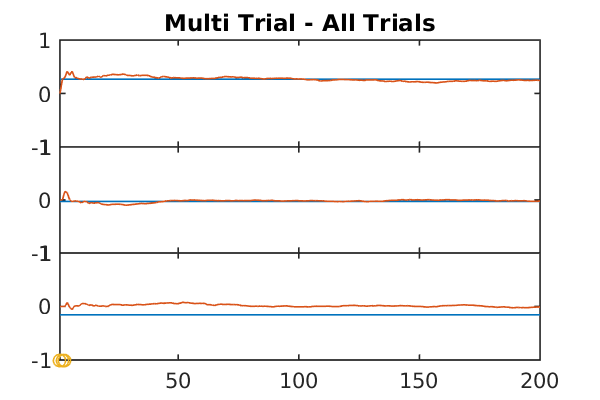

In [6]:
order_est = 3;
verbosity = 0;

lambda = 0.99;
filter = MCMTQRDLSL1(ntrials,nchannels,order_est,lambda);
trace = LatticeTrace(filter,'fields',{'Kf'});

% run the filter
figure;
plot_options_cust = [plot_options {'title','Multi Trial - All Trials'}];
trace.run(x,'verbosity',verbosity,'mode','plot',...
    'plot_options',plot_options_cust);

## Multi-channel multi-trial QRDLSL1 with 2 trials

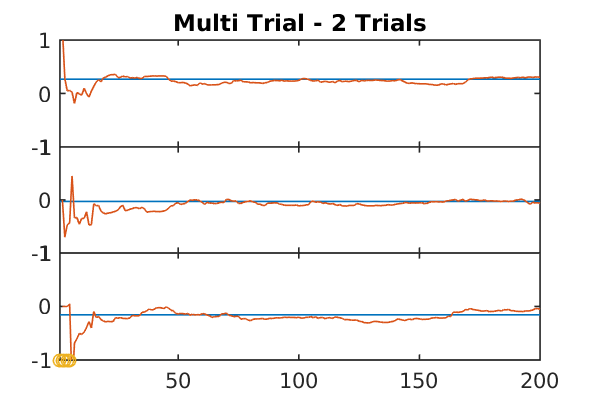

In [7]:
lambda = 0.99;
filter = MCMTQRDLSL1(2,nchannels,order_est,lambda);
trace = LatticeTrace(filter,'fields',{'Kf'});

% run the filter
figure;
plot_options_cust = [plot_options {'title','Multi Trial - 2 Trials'}];
trace.run(x(:,:,1:2),'verbosity',verbosity,'mode','plot',...
    'plot_options',plot_options_cust);

## Multi-channel QRDLSL on single trial

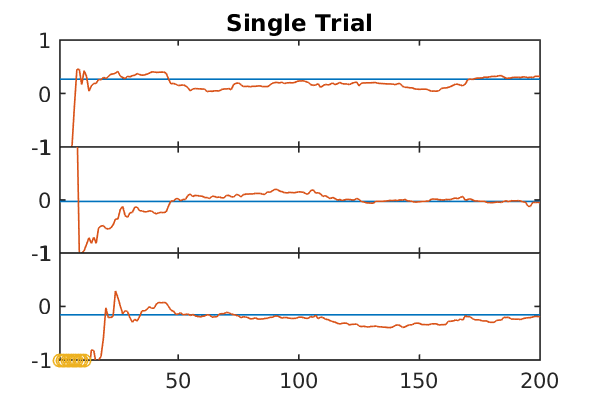

In [8]:
filter = MQRDLSL1(nchannels,order_est,lambda);
% filter = MQRDLSL2(nchannels,order_est,lambda);
trace = LatticeTrace(filter,'fields',{'Kf'});

% run the filter
figure;
plot_options_cust = [plot_options {'title','Single Trial'}];
trace.run(x(:,:,1),'verbosity',verbosity,'mode','plot',...
    'plot_options',plot_options_cust);